In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import sys
from importlib import reload

import crispr_assembler as ca

import pickle 
%load_ext autoreload
%autoreload 2

In [2]:
np.linspace(0,10,2)

array([ 0., 10.])

In [3]:

sys.path.append("../crispr_assembler/crispr_assembler/src/utils/")

In [5]:
reads, quals = ca.read_fastq("../data/cdif_11_12_bc/assembled/-merged.assembled.fastq")

In [3]:
import regex as re

In [4]:
m1s = 'AAGCAGTGGTATCAACGCAGAGT'

In [5]:
p = re.compile('(?:'  + m1s + '){e<=2}')
p_cut = re.compile('(?:' + m1s[-11:] + '){e<=2}')
p_rc = re.compile('(?:' + ca.rc(m1s, r = 1) + '){e<=2}')
p_rc_cut = re.compile('(?:' + ca.rc(m1s[-11:], r = 1) + '){e<=2}')

In [6]:
from tqdm import tqdm_notebook

In [7]:
read = reads[2]

NameError: name 'reads' is not defined

In [10]:
def extract_read_bc(read, pattern, search_rc=0):
    coords = [x.span() for x in re.finditer(pattern, read)]
    rc = 0
    if len(coords) == 0 and search_rc:
        read = ca.rc(read, r=1)
        coords = [x.span() for x in re.finditer(pattern, read)]
        rc = 1
    if len(coords) != 0:        
        bc_start = [x.span() for x in re.finditer(pattern, read)][0][1]
        bc_end = bc_start + 10

        bc = read[bc_start: bc_end]
        read_cut = read[bc_end:]

        return bc, read_cut, read, rc
    else:
        return -1, -1, -1, -1

In [14]:
#reads_clusterized = pickle.load(open("../../notebooks/barcodes/no_mp", 'rb'))
reads_clusterized = ca.dict_from_csv("../../notebooks/barcodes/no_mp")

In [24]:
reads_clusterized = pickle.load(open("../../notebooks/barcodes/reads_bc_cdif", 'rb'))

In [25]:
reads_clusterized

{'CNAANGTTGT': ['CCATTTAGTTAATATAAAACACCACATCAAAGTTATCTTTAATAGAAGTTATCTCCTATTTACATTCCATATAGTTAATATAAAACNTTGGCACTATTATTTGCACAGGATAAGGCTGATGGATTTACATTCCATATAGTCGAGATNT'],
 'ATGTCGTGCC': ['CCACTTAGTTAATATAAAACTTTATATTTCGTCGCACGGATTCGTGCGAAGGGTTGGATTTACATACCACTTAGT'],
 'NCTNTTCANG': ['CCATATAGTTAATATAAAACTATTATAAGGAGCATTATACGACCAAAAGCCAAAGCAGCTTTACATTCCATATAGTTAATATAAAACAAGCAACAGCAAGAGTCGCGACAACATTAAAAACTTCCTTTACATTCCATATAGTCGAGATNT'],
 'GTCAGTACAC': ['CCACTTAGTTAATATAAAACTAACACTCTATAATAAAAAACTGCCCNTGTAATCAAACTTTACATACCACTTAGTTAATATAAAACTAAACGCTTTTACAATAGTTTTTCCTANATNTTTCGCTTTACATACCACTTAGT'],
 'TCATATTGGG': ['CCACTTAGTTAATATAAAACCATCCCATTCAGCAACAACAGTCGCTAAATCTTCTGCCTTTACATACCACATAGT'],
 'GGACCAGTTA': ['CCACTTAGTTAATATAAAACTATACTGGGCAAGGAAAGTTTATCCTACACTTGTTTGTCTTTACATACCACATAGTCGAGCTGA'],
 'GGTCTGCGTG': ['CCATATAGTTAATATAAAACTAAGCGATATTAGAGAGCGCAAGGCATAGCGGAGCAAATTTACATACCACATAGTCGAGATGT'],
 'TTTTGGTTGG': ['CCACTTAGTTAATATAAAACCGTCTACTGTTGCATCATTTAGTGACCTAGCACTTTGATTTACATACCACTTAGT'],
 '

In [13]:
def sample_from_dict(d):
    return [x for x in d.values()][:10]

In [90]:
def split_read_rc(read, repeat, quality=None):
    if quality is None:
        quality = 'Z' * len(read)

    spacers = ca.split_read(read, quality, repeat)#.reverse_complementary())
    inv = 0
    print(spacers)
    if spacers[0][0] == -1 or spacers[1][0] == -1:
        print('si')
        spacers = ca.split_read(ca.rc(read, r=1), quality, repeat)#.reverse_complementary())
        inv = 1

    if spacers[0] == -1 or spacers[1] == -1:
        return (-1,-1), -1
    else:
        if inv:
            return [[ca.rc(x, r=1) for x in y] for y in spacers][::-1], inv
        else:
            return spacers, inv

In [29]:
reads = sample_from_dict(reads_clusterized)

In [31]:
reads[0][0]

'CCATTTAGTTAATATAAAACACCACATCAAAGTTATCTTTAATAGAAGTTATCTCCTATTTACATTCCATATAGTTAATATAAAACNTTGGCACTATTATTTGCACAGGATAAGGCTGATGGATTTACATTCCATATAGTCGAGATNT'

In [37]:
split_read_rc(reads[2][0], ca.redundant.reverse_complementary())

((['GAAGTTTTTAATGTTGTCGCGACTCTTGCTGTTGC',
   'CTGCTTTGGCTTTTGGTCGTATAATGCTCCTTATAA'],
  ['ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ',
   'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ']),
 0)

In [ ]:
split_read_rc(reads[2][0], ca.redundant.reverse_complementary())

In [38]:
reads[2][0]

'CCATATAGTTAATATAAAACTATTATAAGGAGCATTATACGACCAAAAGCCAAAGCAGCTTTACATTCCATATAGTTAATATAAAACAAGCAACAGCAAGAGTCGCGACAACATTAAAAACTTCCTTTACATTCCATATAGTCGAGATNT'

In [96]:
ca.split_read(reads[2][0],ca.redundant)

(['GAAGTTTTTAATGTTGTCGCGACTCTTGCTGTTGC',
  'CTGCTTTGGCTTTTGGTCGTATAATGCTCCTTATAA'],
 ['ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ',
  'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ'],
 1)

In [98]:
ca.split_read(ca.rc(reads[2][0], r=1), ca.redundant)

(['GAAGTTTTTAATGTTGTCGCGACTCTTGCTGTTGC',
  'CTGCTTTGGCTTTTGGTCGTATAATGCTCCTTATAA'],
 ['ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ',
  'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ'],
 0)

In [88]:
ca.split_read(reads[2][0],reads[2][0],ca.redundant.reverse_complementary())

(['TATTATAAGGAGCATTATACGACCAAAAGCCAAAGC',
  'AAGCAACAGCAAGAGTCGCGACAACATTAAAAACT'],
 ['TATTATAAGGAGCATTATACGACCAAAAGCCAAAGC',
  'AAGCAACAGCAAGAGTCGCGACAACATTAAAAACT'])

In [93]:
split_read_rc(reads[2][0], ca.redundant)

([-1, -1], [-1, -1])
si


([['ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ',
   'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ'],
  ['GCAACAGCAAGAGTCGCGACAACATTAAAAACTTC',
   'TTATAAGGAGCATTATACGACCAAAAGCCAAAGCAG']],
 1)

In [92]:
split_read_rc(reads[2][0], ca.redundant.reverse_complementary())

(['TATTATAAGGAGCATTATACGACCAAAAGCCAAAGC', 'AAGCAACAGCAAGAGTCGCGACAACATTAAAAACT'], ['ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ', 'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ'])


((['TATTATAAGGAGCATTATACGACCAAAAGCCAAAGC',
   'AAGCAACAGCAAGAGTCGCGACAACATTAAAAACT'],
  ['ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ',
   'ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ']),
 0)

In [68]:
ca.redundant.rc

'GTTTTAKATTAACTAWRTGGWATGTAAAK'

In [72]:
ca.find(ca.redundant.rc, reads[2][0])

[]

In [73]:
ca.find(ca.rc(ca.redundant.rc, r=1), reads[2][0])

[(56, 87)]

In [58]:
split_read_rc(reads[2][0], ca.redundant)

(([-1, -1], [-1, -1]), 0)

In [54]:
ca.redundant.rc

'GTTTTAKATTAACTAWRTGGWATGTAAAK'

In [55]:
ca.redundant.reverse_complementary().rc

'MTTTACATWCCAYWTAGTTAATMTAAAAC'

In [11]:
def process_batch(batch):
    reads_clusterized = {}
    for r in tqdm_notebook(batch):
        bc, r_cut, r, inv = extract_read_bc(r, p_cut)
        if bc != -1:
            if bc in reads_clusterized:
                reads_clusterized[bc].append(r_cut)
                #print (f'mrgd {bc}')
            else:
                reads_clusterized[bc] = [r_cut]
                
    return reads_clusterized

In [27]:
def get_splits(max_idx, n_splits):
    splits = []
    spl = np.linspace(0, max_idx, n_splits, dtype=int)
    for i, j in zip(spl[:-1], spl[1:]):
        splits.append((i, j))
        
    return splits

In [34]:
reads_batches = [reads[idxs[0]: idxs[1]] for idxs in get_splits(len(reads), 6)]

In [39]:
[len(x) for x in reads_batches]

[697336, 697337, 697336, 697337, 697337]

In [14]:
reads_clusterized = process_batch(reads)

A Jupyter Widget

In [54]:
clusters_array = p.map(process_batch, reads_batches)

KeyboardInterrupt: 

In [30]:
p.close()

In [35]:
del read

In [31]:
%whos

Variable            Type        Data/Info
-----------------------------------------
Pool                method      <bound method BaseContext<...>bject at 0x7ff8727c93c8>>
ca                  module      <module 'crispr_assembler<...>r_assembler/__init__.py'>
extract_read_bc     function    <function extract_read_bc at 0x7ff83d059d08>
m1s                 str         AAGCAGTGGTATCAACGCAGAGT
np                  module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
p                   Pool        <multiprocessing.pool.Poo<...>object at 0x7ff7622794a8>
p_cut               Pattern     regex.Regex('(?:CAACGCAGA<...>){e<=2}', flags=regex.V0)
p_rc                Pattern     regex.Regex('(?:ACTCTGCGT<...>){e<=2}', flags=regex.V0)
p_rc_cut            Pattern     regex.Regex('(?:ACTCTGCGT<...>){e<=2}', flags=regex.V0)
plt                 module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
process_batch       function    <function process_batch at 0x7ff7ca1fc6a8>
qual

In [18]:
len(reads_clusterized)

507007

In [15]:
import pickle

In [16]:
pickle.dump(reads_clusterized, open("../data/cdif_11_12_bc/reads_clustred_bc_fwd", 'wb'))

In [22]:
lens = []
for k,v in reads_clusterized.items():
    lens = len(v)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

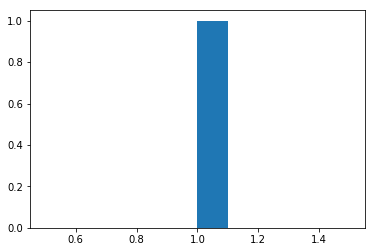

In [23]:
plt.hist(lens)

In [30]:
ca.rc("ATTTACATTCCATATAGTTAATCTAAAAC", r=1)

'GTTTTAGATTAACTATATGGAATGTAAAT'

In [33]:
ca.rc(ca.redundant.rc, r=1)

'MTTTACATWCCAYWTAGTTAATMTAAAAC'

In [32]:
ca.repeat_to_re_pattern(ca.rc("ATTTACATTCCATATAGTTAATCTAAAAC", r=1))

'(GTTTTAGATTAACTATATGGAATGTAAAT){e<=2}'

In [34]:
ca.find(ca.rc(ca.redundant.rc, r=1), reads[2])

[(89, 120)]

In [50]:
ca.split_read(reads[0], reads[0], ca.redundant.reverse_complementary())

(['ACCACATCAAAGTTATCTTTAATAGAAGTTATCTC', 'NTTGGCACTATTATTTGCACAGGATAAGGCTGAT'],
 ['ACCACATCAAAGTTATCTTTAATAGAAGTTATCTC', 'NTTGGCACTATTATTTGCACAGGATAAGGCTGAT'])

In [43]:
import importlib

ca = importlib.reload(ca)

In [44]:
ca.redundant.rc

'GTTTTAKATTAACTAWRTGGWATGTAAAK'

In [49]:
ca.redundant.reverse_complementary().rc

'MTTTACATWCCAYWTAGTTAATMTAAAAC'

In [17]:
reads_splits = {}

for k, v in tqdm_notebook(reads_clusterized.items()):
    reads_splits[k] = ca.split_read(v[0], 'Z' * len(v), ca.redundant.reverse_complementary())

A Jupyter Widget

In [28]:
sample_from_dict(reads_clusterized)[0]

['CCATTTAGTTAATATAAAACACCACATCAAAGTTATCTTTAATAGAAGTTATCTCCTATTTACATTCCATATAGTTAATATAAAACNTTGGCACTATTATTTGCACAGGATAAGGCTGATGGATTTACATTCCATATAGTCGAGATNT']

In [35]:
ca.split_read(sample_from_dict(reads_clusterized)[2][0], 'Z' * len(v), ca.redundant.reverse_complementary())

([-1, -1], [-1, -1])

In [6]:
len(reads_splits)

NameError: name 'reads_splits' is not defined

In [36]:
pickle.dump(reads_splits, open("../data/cdif_11_12_bc/reads_splits_bc_fwd", 'wb'))

In [16]:
reads_splits_f = {}

for k, v in tqdm_notebook(reads_splits.items()):
    if v[1] != -1 and v[0] != -1 and len(v) > 0:
        reads_splits_f[k] = v

A Jupyter Widget

In [2]:
import pickle

In [3]:
reads_splits = pickle.load(open("./reads_splited_cdif", 'rb'))

In [17]:
len(reads_splits_f)

316845

In [65]:
with open("../../data/cdif_11_12/out/restored/Cdif-planeA_S6_L001_R1_001_arrays_num") as f:
    arrs = [[int(y) for y in x[:-1].split(', ')] for x in  f.readlines()]

In [71]:
with open("../../data/cdif_11_12/out/restored/Cdif-planeA_S6_L001_R1_001_weights") as f:
    weights = [[int(y) for y in x[:-1].split(', ') if len(y) > 0] for x in  f.readlines()]

In [8]:
cl_to_ind = ca.dict_from_csv("../../data/cdif_11_12/out/restored/Cdif-planeA_S6_L001_R1_001_cl_to_ind")

In [62]:
gr_ans = ca.list_to_gr(arrs, 500)

In [10]:
gr_bc = np.zeros_like(gr_ans)

In [18]:
def find_closest_rc(d, sp, t=5):
    answ_1 = ca.find_closest(d, sp)
    answ_2 = ca.find_closest(d, ca.rc(sp, r=1))
    if answ_1[0] < answ_2[0] and answ_1[0] <= t:
        return answ_1
    elif answ_2[0] <= answ_1[0] and answ_2[0] <= t:
        return answ_2
    else:
        return [-1,-1]

In [19]:
for k, v in tqdm_notebook(reads_splits_f.items()):
    ind_1 = find_closest_rc(cl_to_ind, v[0])
    ind_2 = find_closest_rc(cl_to_ind, v[1])
     
    if ind_1[0] != -1 and ind_2[0] != -1:
        #print('good')
        gr_bc[int(cl_to_ind[ind_2[1]]),
              int(cl_to_ind[ind_1[1]])] += 1

A Jupyter Widget

In [86]:
cl_to_ind[ca.find_closest(cl_to_ind, v[0])[1]]

'214'

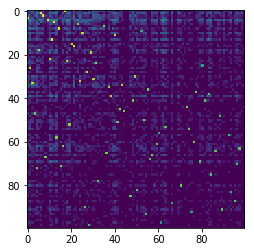

In [64]:
plt.imshow(np.log(gr_bc[:100,:100].T + 1))

In [56]:
arr, weights = ca.restore_arrays(gr_ans)

In [45]:
weights = []

for arr in arrs:
    if len(arr) > 4:
        w = []
        for a,b in zip(arr[:-1], arr[1:]):
            w.append(gr_bc.T[a,b])
        weights.append(w)

In [47]:
sp_weights = []
for i in range(500):
    sp_weights.append(gr_bc[i].sum() + gr_bc[:, i].sum())

In [57]:
weights_bc = []

for arr in arrs:
    w = []
    for a in arr:
        w.append(sp_weights[a])
    weights_bc.append(w)

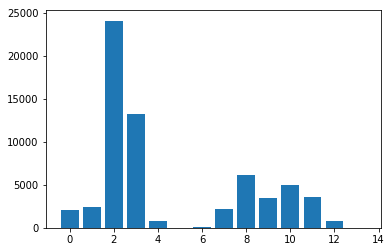

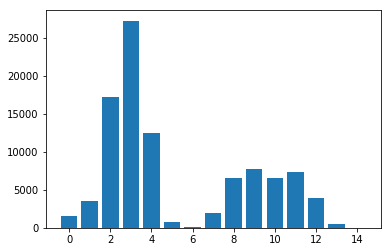

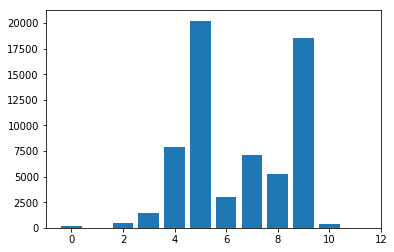

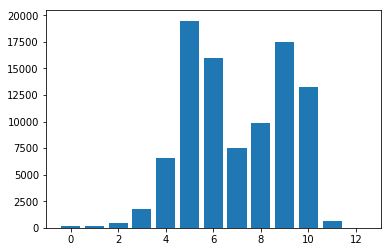

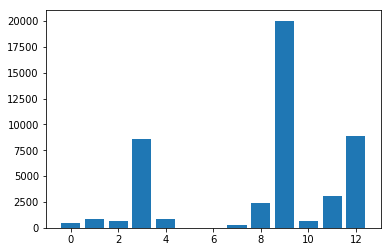

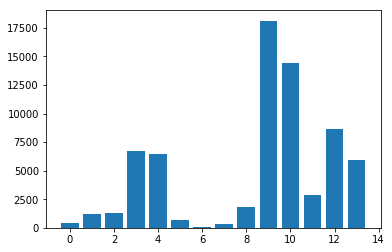

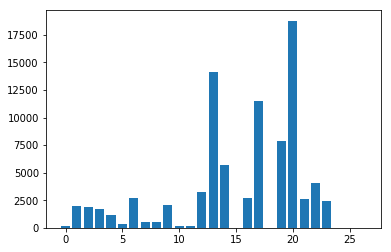

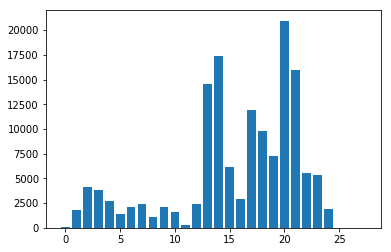

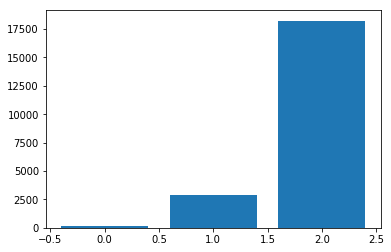

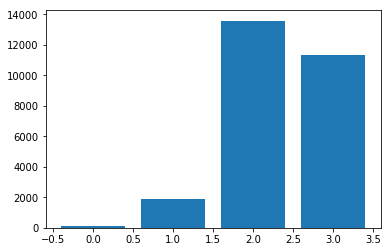

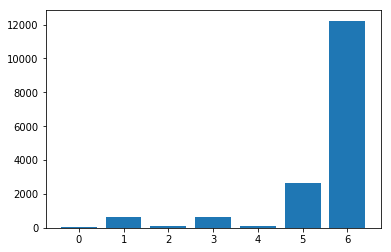

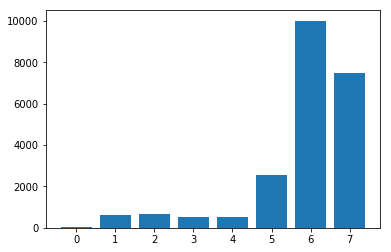

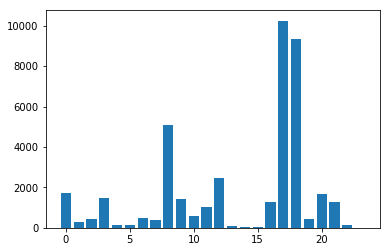

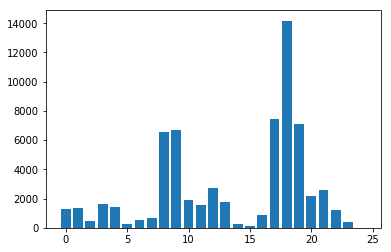

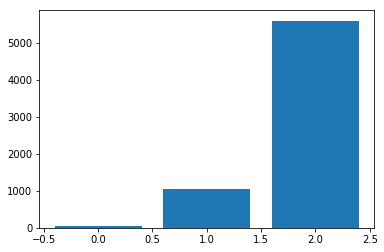

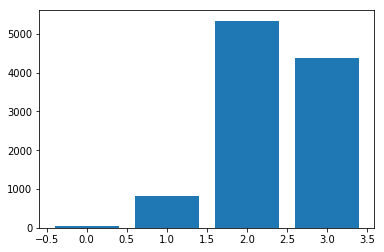

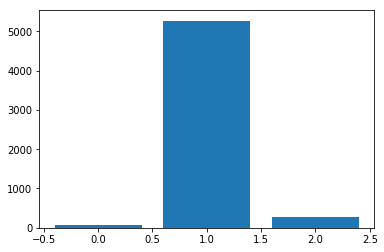

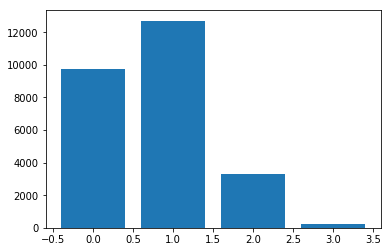

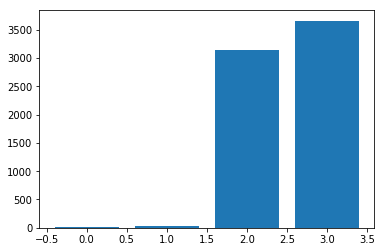

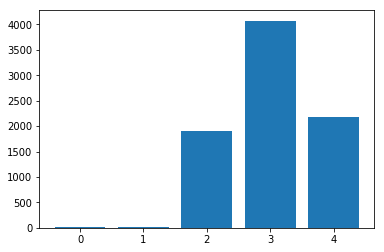

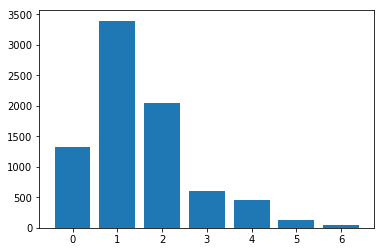

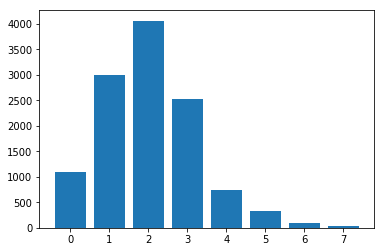

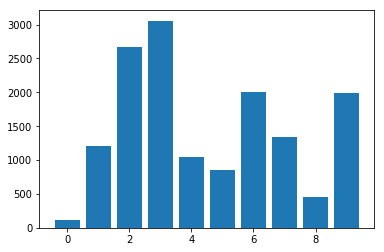

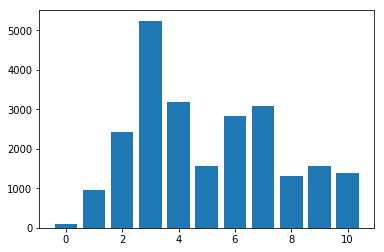

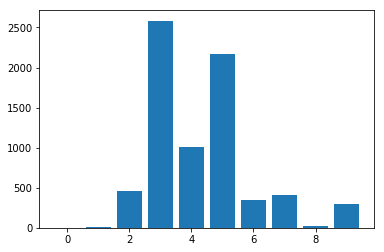

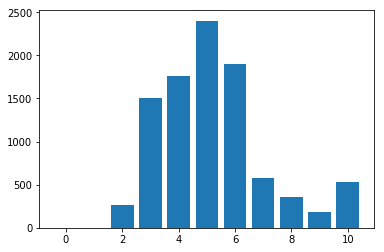

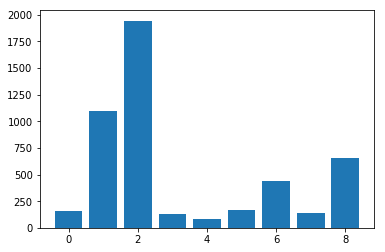

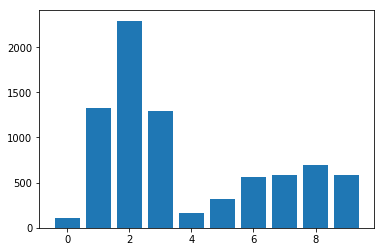

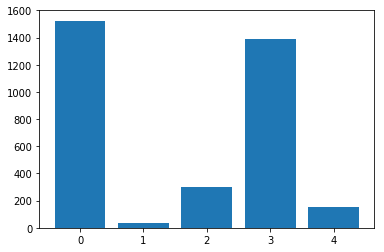

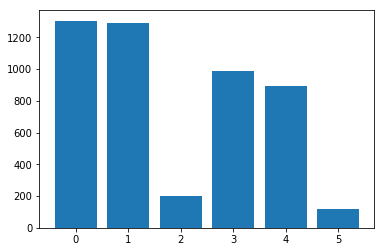

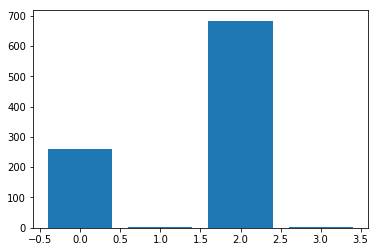

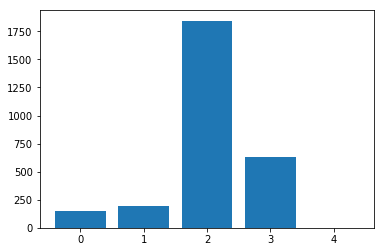

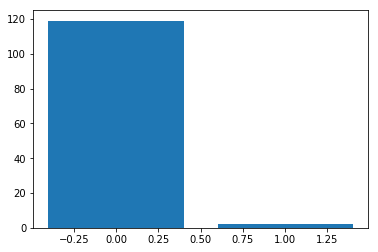

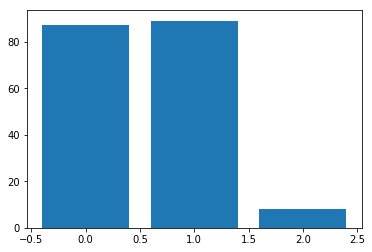

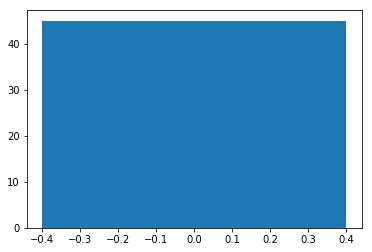

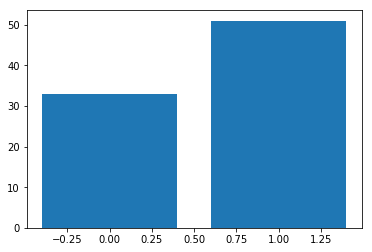

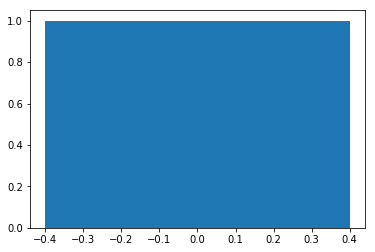

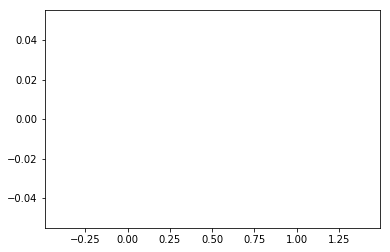

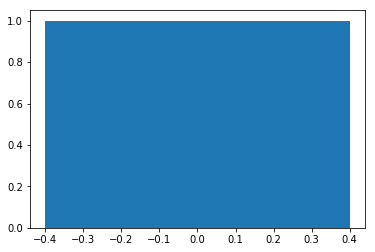

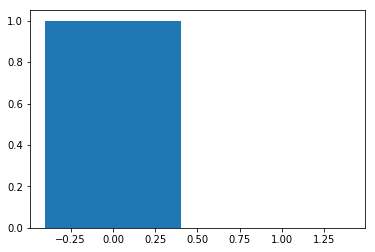

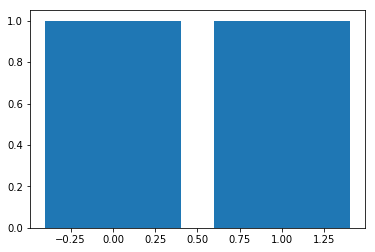

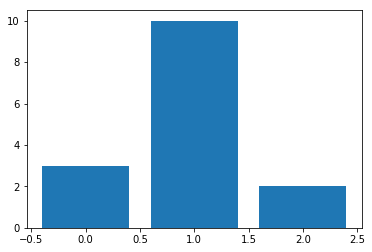

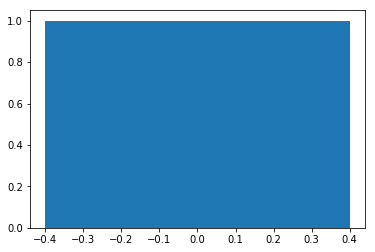

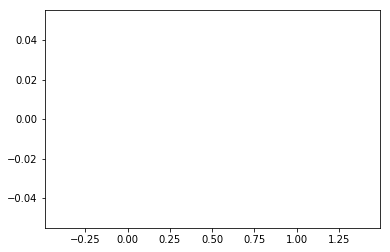

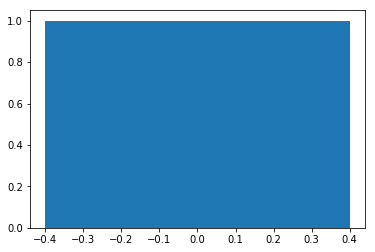

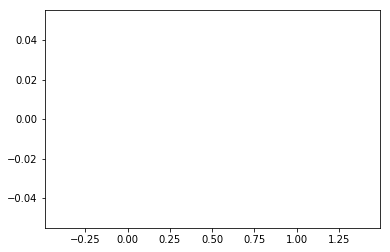

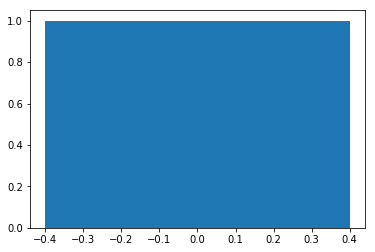

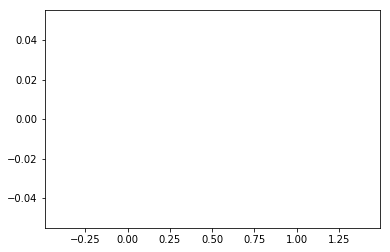

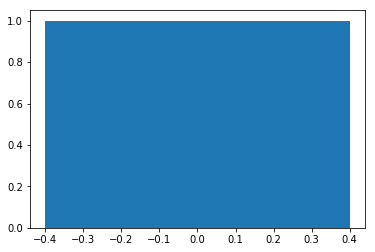

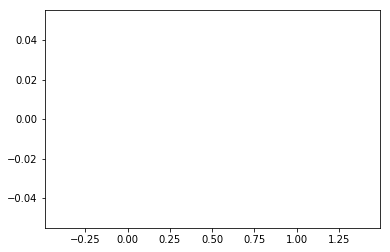

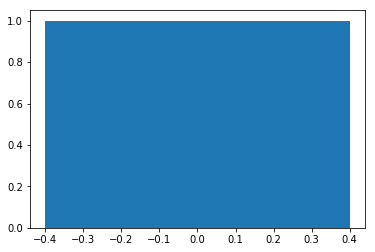

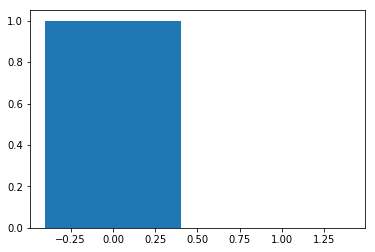

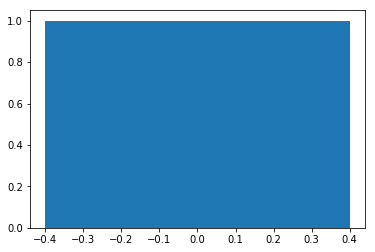

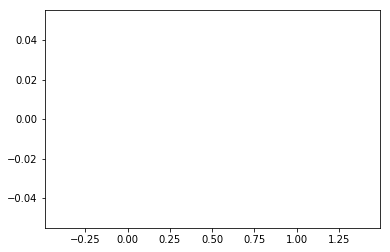

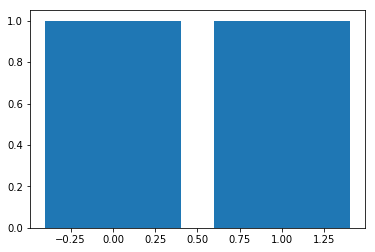

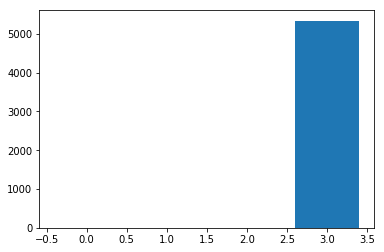

In [73]:
for x,x_bc in zip(weights, weights_bc):
    plt.bar(np.arange(len(x)), x) 
    plt.show()
    plt.bar(np.arange(len(x_bc)), x_bc)
    plt.show()

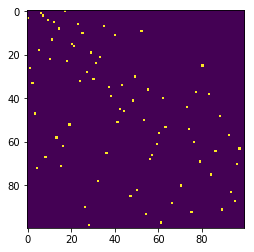

In [21]:
plt.imshow(np.log(gr_ans[:100,:100] + 1))

In [23]:
bcws = []
for arr in arrs:
    bc_w = []
    for a, b in zip(arr, arr[1:]):
        bc_w.append(gr_bc.T[a,b])
    bcws.append(bc_w)

In [24]:
bcws

[[1431.0,
  1908.0,
  14838.0,
  11493.0,
  750.0,
  23.0,
  94.0,
  1752.0,
  4617.0,
  2733.0,
  3607.0,
  3401.0,
  466.0,
  16.0],
 [157.0,
  22.0,
  325.0,
  1266.0,
  4992.0,
  13057.0,
  2396.0,
  4763.0,
  4254.0,
  12529.0,
  475.0,
  7.0],
 [417.0,
  605.0,
  615.0,
  5844.0,
  530.0,
  7.0,
  38.0,
  230.0,
  1582.0,
  13797.0,
  511.0,
  2197.0,
  5902.0],
 [116.0,
  1527.0,
  2258.0,
  1237.0,
  1117.0,
  216.0,
  1672.0,
  497.0,
  451.0,
  1329.0,
  109.0,
  115.0,
  2183.0,
  11405.0,
  5604.0,
  2.0,
  2283.0,
  9361.0,
  2.0,
  6466.0,
  13732.0,
  1999.0,
  3310.0,
  1851.0,
  0.0,
  0.0,
  0.0],
 [119.0, 1757.0, 11284.0],
 [38.0, 562.0, 74.0, 422.0, 74.0, 2380.0, 7462.0],
 [1131.0,
  163.0,
  225.0,
  1235.0,
  125.0,
  97.0,
  363.0,
  299.0,
  5439.0,
  1126.0,
  542.0,
  819.0,
  1631.0,
  78.0,
  62.0,
  22.0,
  811.0,
  6412.0,
  6666.0,
  287.0,
  1657.0,
  861.0,
  137.0,
  0.0],
 [30.0, 733.0, 4150.0],
 [9632.0, 3038.0, 171.0],
 [5.0, 15.0, 1859.0, 2157.0],


In [54]:
lens = []
for v  in reads_splits.values():
    lens.append(len(v))

(array([     0.,      0.,      0.,      0.,      0., 507007.,      0.,
             0.,      0.,      0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <a list of 10 Patch objects>)

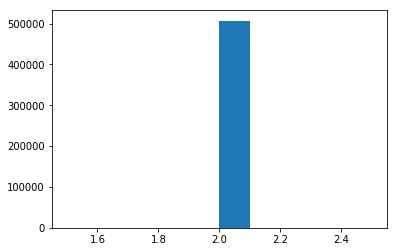

In [55]:
plt.hist(lens)